# 1. Visualisation

Dans ce notebook nous avons pour objectif de récupérer les données sur toutes les stations essences en France métropolitaine sur le site data.gouv. 
Ensuite nous analysons ces données pour faire ressortir caractéristiques les plus pertinentes pour la suite de notre projet.

In [2]:
import module_projet as md
import urllib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import cartiflette.s3
from cartiflette.download import get_vectorfile_ign

Nous récupérons désormais les différents fichier contenant les données grâce aux url de téléchargement du site data.gouv pour avoir respectivement un dataframe avec les données mis à jour à chaque instant sur les stations, un avec les données mise à jour quotidiennement, puis pour avoir un geodataframe avec de la même manière les données instantannées et quotdiennes (toutes les fonctions et variables concernant geopandas seront suivi de _g).

In [3]:

urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-instantane-test-ods-copie/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    "data/fichier_inst.csv")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-quotidien-test-ods/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    "data/fichier_quot.csv")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-instantane-test-ods-copie/download/?format=geojson&timezone=Europe/Berlin&lang=fr",
    "data/fichier_inst_g.geojson")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-quotidien-test-ods/download/?format=geojson&timezone=Europe/Berlin&lang=fr",
    "data/fichier_quot_g.geojson")



('data/fichier_quot_g.geojson', <http.client.HTTPMessage at 0x2be692f45e0>)

In [4]:
dat_inst = pd.read_csv('data/fichier_inst.csv', sep= ';')
dat_quot =pd.read_csv('data/fichier_quot.csv', sep= ';')
dat_inst_g = gpd.read_file('data/fichier_inst_g.geojson')
data_quot_g = gpd.read_file('data/fichier_quot_g.geojson')

Les dataframes instantannés et quotidiens étant similaire que ce soit avec pandas ou geopandas, on se concentre pour l'instant uniquement sur les dataframes pandas.

In [5]:
dat_inst.groupby('prix_nom').id.count()

prix_nom
E10       6762
E85       3082
GPLc      1361
Gazole    9426
SP95      3734
SP98      7615
Name: id, dtype: int64

In [6]:
dat_quot.groupby('prix_nom').id.count()

prix_nom
E10       14308
E85        5693
GPLc       2218
Gazole    22275
SP95       9297
SP98      16657
Name: id, dtype: int64

On veut nettoyer nos données en gardant selement les colonnes intéréssantes et selon le carburant que notre usager à choisi, nous prendrons ici le Gazole car c'est le carburant le plus présent en France comme on peut le voir. 
On définit donc maintenant des fonctions pour avoir des dataframes gardant uniquement les données qui nous intéressent selon le carburant qui nous intéresse.

In [7]:
def data_carb(df, carb, colonnes_utiles):
    data_1 = df[df.prix_nom == carb]
    d = data_1[colonnes_utiles]
    d.drop_duplicates(keep = 'first', inplace=True) 
    return d

In [17]:
df_visu_inst = data_carb(dat_inst,"Gazole", ['id','adresse', 'ville', 'geom','prix_valeur', 'Code Officiel Département',
       'Nom Officiel Département'])
df_visu_quot = data_carb(dat_quot,"Gazole", ['id','adresse', 'ville', 'geom', 'prix_valeur', 'Code Officiel Département',
       'Nom Officiel Département'])

In [9]:
print(df_visu_inst.shape)
print(df_visu_quot.shape)


(9426, 6)
(9326, 6)


On travaillera ensuite uniquement sur le data_frame instantanné puisque les dataframes actuels sont presque identiques. 

On compte par département le nombre de stations essence pour avoir une idée de où l'on trouve le plus de stations en France et en Ile-de-France.

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z
Data have been previously downloaded and are still available in C:\Users\arman\AppData\Local\Temp/COG-2022


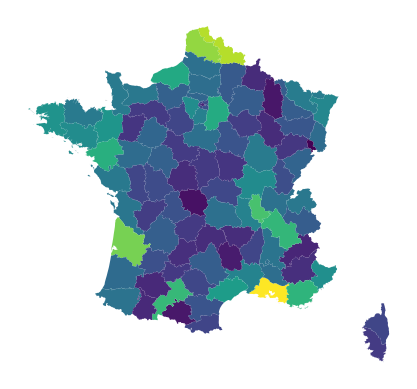

In [10]:
dep = get_vectorfile_ign(
  level = "DEPARTEMENT", field = "metropole",
  source = "COG", provider="opendatarchives")

series = df_visu_inst.groupby('Code Officiel Département').id.count() #series avec le nombre de stations par département

for i in range(len(dep)):
    dep.loc[i, 'count_stations'] = int(series.iloc[dep.INSEE_DEP[i] == series.index]) 
    #on ajoute une colonne avec le nombre de stations en faisant correspondre les départements de dep et de la series
ax = dep.plot(column = "count_stations")
ax.set_axis_off()

Le nombre de stations à l'air d'être repartie assez aléatoirememt, on prendra donc comme adresse de référence celle de l'un des membres du groupe :  1 rue d'Arsonval, Orsay, France.


Pour savoir le nombre de stations que l'on va proposer à l'usager on regarde le nombre de station autour de l'usager en fonction de la distance. 

In [11]:
def Adresse_to_gps(Adresse) : #Fonction
    geolocator = Nominatim(user_agent="Projet Python")
    location = geolocator.geocode(Adresse)
    return str(str(location.latitude) + ','+ str(location.longitude))

In [13]:
def nb_station(df,Adresse, rayon) : #calcul de nb de station dans un rayon spécifié
    n=0
    position= Adresse_to_gps(Adresse)
    
    A = list(map(float,position.split(',')))
    for station in range(len(df)) : 
        B = list(map(float,df.iloc[station,3].split(',')))
        D=md.distanceGPS(A,B)
        if D<rayon : 
            n=n+1
    return n 

print(nb_station(df_visu_inst, "1 rue d'Arsonval, Orsay, France", 200000))

137


On veut afficher une courbe qui nous montre le nombre de stations accessibles en indiquant une distance maximum de notre point de départ

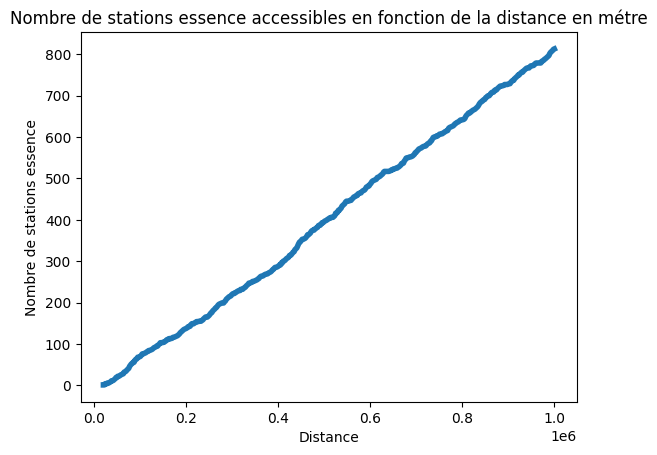

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20000, 1000000, 500)
y=[]

for l in range(len(x)) : #prend 7min !
    y.append(nb_station(df_visu_inst, "1 rue d'Arsonval, Orsay, France", x[l]))

plt.plot(x, y, linewidth=4)
plt.xlabel("Distance")
plt.ylabel("Nombre de stations essence")
plt.title("Nombre de stations essence accessibles en fonction de la distance en métre")


plt.show()

On observe clairement une croissance linéaire avec une pente importante, en effet comme on utilise un rayon comme limite de distance, le nombre de stations accessibles croit très vite. Nous pensons que ce graphique justifie notre projet car on peut vite se demander, jusqu'où est-il intéressant de rouler pour trouver les meilleurs prix.

On souhaite maintenant visualiser la répartition des prix du carburant en France metropolitaine

In [18]:
#calcul du prix du carburant par département


Prix_moy_dep_code=df_visu_inst.groupby('Code Officiel Département')['prix_valeur'].mean()
Prix_moy_dep_nom=df_visu_inst.groupby('Nom Officiel Département')['prix_valeur'].mean()


In [ ]:
#pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#pip install git+https://github.com/inseefrlab/cartogether

In [19]:
from cartiflette.download import get_vectorfile_ign #carte de la France à l'échelle des départements
france = get_vectorfile_ign(
  level = "DEPARTEMENT",
  field = "metropole",
  source = "COG",
  provider="opendatarchives"
  )
  
Fr_prix=france.merge(Prix_moy_dep_code, how='inner', left_on='INSEE_DEP', right_on='Code Officiel Département')
#jointure avec le prix de l'essence sur l'indicatif de département

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z
Data have been previously downloaded and are still available in C:\Users\arman\AppData\Local\Temp/COG-2022


<AxesSubplot: >

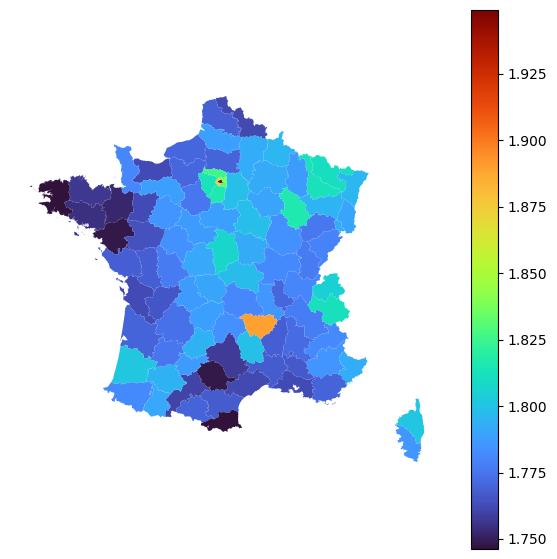

In [36]:
fig,ax = plt.subplots(figsize=(7, 7)) 
Fr_prix.plot(ax = ax, column = "prix_valeur", legend=True, cmap='turbo')
ax.set_axis_off()
ax #affichage de la carte de France en différenciant les département selon le prix du carburant


On observe une distribution assez uniforme certes, mais avec des écarts importants pour quelques départements. A noter qu'une différence de seulement quelques centimes peut faire une grande différence sur le prix du plein. Cette carte montre à notre avis, une disparité assez grande entre les prix du carburants pour justifier notre étude. 